In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the input CSV files
main_data = pd.read_csv('ss.csv')  # Replace with your main dataset file path
ensemble_features = pd.read_csv('final_ensemble_features.csv')  # Replace with your ensemble features file path

# Merge datasets on 'AMH(ng/mL)' (use inner join to only keep rows that exist in both datasets)
df = pd.merge(main_data, ensemble_features, on='AMH(ng/mL)', how='inner')

# Drop any duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Drop rows with missing target values
df.dropna(subset=['PCOS (Y/N)_x'], inplace=True)

# Convert 'PCOS (Y/N)_x' to numeric if needed (already seems numeric from your data)
y = df['PCOS (Y/N)_x'].astype(int)

# Define the feature set (X) by dropping non-numeric and target columns
X = df.drop(['PCOS (Y/N)_x', 'PCOS (Y/N)_y'], axis=1)

# Convert any non-numeric columns to numeric using label encoding or one-hot encoding
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Check if there are any NaN values and fill or remove them
X.fillna(X.mean(), inplace=True)  # Fill NaNs with column means

# Feature scaling (optional, but recommended for SVM and KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the machine learning models (with hyperparameter tuning for Random Forest)
models = {
    'SVM': SVC(probability=True),
    'Linear Regression': LinearRegression(),  # Not suitable for classification but included
    'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=10,
                                            min_samples_leaf=4, max_features='sqrt', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Perceptron': Perceptron()
}

# Dictionary to store the results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # For Linear Regression, we'll convert predictions to binary
    if model_name == 'Linear Regression':
        y_pred = (y_pred >= 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # AUC is not calculated for models that don't provide predict_proba
    if hasattr(model, "predict_proba"):
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:
        auc = 0.0  # Set AUC to 0 if not applicable

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc
    }

# Create a DataFrame for displaying the results
results_df = pd.DataFrame(results).T

# Formatting the output for better presentation (percentage format)
for metric in results_df.columns:
    results_df[metric] = results_df[metric].apply(lambda x: f"{x:.3f} ({x * 100:.1f}%)" if x is not None else "0.000 (0.0%)")

# Display the results in a table format
print("Model Evaluation Metrics:")
print(results_df.to_string(index=True, header=True))

# Finding the model with the highest metrics
highest_accuracy_model = results_df['Accuracy'].idxmax()
highest_precision_model = results_df['Precision'].idxmax()
highest_recall_model = results_df['Recall'].idxmax()
highest_f1_model = results_df['F1 Score'].idxmax()
highest_auc_model = results_df['AUC Score'].idxmax()

# Display the highest metrics models
print("\nModels with highest metrics:")
print(f"Highest Accuracy: {highest_accuracy_model} with {results_df['Accuracy'][highest_accuracy_model]}")
print(f"Highest Precision: {highest_precision_model} with {results_df['Precision'][highest_precision_model]}")
print(f"Highest Recall: {highest_recall_model} with {results_df['Recall'][highest_recall_model]}")
print(f"Highest F1 Score: {highest_f1_model} with {results_df['F1 Score'][highest_f1_model]}")
print(f"Highest AUC Score: {highest_auc_model} with {results_df['AUC Score'][highest_auc_model]}")


Model Evaluation Metrics:
                        Accuracy      Precision         Recall       F1 Score      AUC Score
SVM                0.948 (94.8%)  0.948 (94.8%)  0.948 (94.8%)  0.947 (94.7%)  0.990 (99.0%)
Linear Regression  0.885 (88.5%)  0.888 (88.8%)  0.885 (88.5%)  0.882 (88.2%)   0.000 (0.0%)
Random Forest      0.961 (96.1%)  0.963 (96.3%)  0.961 (96.1%)  0.960 (96.0%)  0.996 (99.6%)
KNN                0.879 (87.9%)  0.892 (89.2%)  0.879 (87.9%)  0.872 (87.2%)  0.984 (98.4%)
Naive Bayes        0.852 (85.2%)  0.856 (85.6%)  0.852 (85.2%)  0.846 (84.6%)  0.874 (87.4%)
Perceptron         0.902 (90.2%)  0.901 (90.1%)  0.902 (90.2%)  0.901 (90.1%)   0.000 (0.0%)

Models with highest metrics:
Highest Accuracy: Random Forest with 0.961 (96.1%)
Highest Precision: Random Forest with 0.963 (96.3%)
Highest Recall: Random Forest with 0.961 (96.1%)
Highest F1 Score: Random Forest with 0.960 (96.0%)
Highest AUC Score: Random Forest with 0.996 (99.6%)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the input CSV file (without using ensemble features)
main_data = pd.read_csv('ss.csv')  # Replace with your main dataset file path

# Drop rows with missing target values
main_data.dropna(subset=['PCOS (Y/N)'], inplace=True)

# Convert 'PCOS (Y/N)' to numeric if needed
y = main_data['PCOS (Y/N)'].astype(int)

# Define the feature set (X) by dropping non-numeric and target columns
X = main_data.drop(['PCOS (Y/N)'], axis=1)

# Convert any non-numeric columns to numeric using label encoding
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Check if there are any NaN values and fill or remove them
X.fillna(X.mean(), inplace=True)  # Fill NaNs with column means

# Feature scaling (optional, but recommended for SVM and KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the machine learning models (with hyperparameter tuning for Random Forest)
models = {
    'SVM': SVC(probability=True),
    'Linear Regression': LinearRegression(),  # Not suitable for classification but included
    'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=10,
                                            min_samples_leaf=4, max_features='sqrt', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Perceptron': Perceptron()
}

# Dictionary to store the results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # For Linear Regression, we'll convert predictions to binary
    if model_name == 'Linear Regression':
        y_pred = (y_pred >= 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # AUC is calculated for models that provide predict_proba
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
    else:
        auc_score = 0.0  # Set AUC to 0 if not applicable

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc_score
    }

# Create a DataFrame for displaying the results
results_df = pd.DataFrame(results).T

# Formatting the output for better presentation (percentage format)
for metric in results_df.columns:
    results_df[metric] = results_df[metric].apply(lambda x: f"{x:.3f} ({x * 100:.1f}%)" if x is not None else "0.000 (0.0%)")

# Display the results in a table format
print("Model Evaluation Metrics:")
print(results_df.to_string(index=True, header=True))

# Finding the model with the highest metrics
highest_accuracy_model = results_df['Accuracy'].idxmax()
highest_precision_model = results_df['Precision'].idxmax()
highest_recall_model = results_df['Recall'].idxmax()
highest_f1_model = results_df['F1 Score'].idxmax()
highest_auc_model = results_df['AUC Score'].idxmax()

# Display the highest metrics models
print("\nModels with highest metrics:")
print(f"Highest Accuracy: {highest_accuracy_model} with {results_df['Accuracy'][highest_accuracy_model]}")
print(f"Highest Precision: {highest_precision_model} with {results_df['Precision'][highest_precision_model]}")
print(f"Highest Recall: {highest_recall_model} with {results_df['Recall'][highest_recall_model]}")
print(f"Highest F1 Score: {highest_f1_model} with {results_df['F1 Score'][highest_f1_model]}")
print(f"Highest AUC Score: {highest_auc_model} with {results_df['AUC Score'][highest_auc_model]}")


Model Evaluation Metrics:
                        Accuracy      Precision         Recall       F1 Score      AUC Score
SVM                0.862 (86.2%)  0.863 (86.3%)  0.862 (86.2%)  0.855 (85.5%)  0.944 (94.4%)
Linear Regression  0.872 (87.2%)  0.870 (87.0%)  0.872 (87.2%)  0.867 (86.7%)   0.000 (0.0%)
Random Forest      0.881 (88.1%)  0.881 (88.1%)  0.881 (88.1%)  0.876 (87.6%)  0.957 (95.7%)
KNN                0.881 (88.1%)  0.881 (88.1%)  0.881 (88.1%)  0.876 (87.6%)  0.930 (93.0%)
Naive Bayes        0.872 (87.2%)  0.874 (87.4%)  0.872 (87.2%)  0.873 (87.3%)  0.894 (89.4%)
Perceptron         0.835 (83.5%)  0.835 (83.5%)  0.835 (83.5%)  0.835 (83.5%)   0.000 (0.0%)

Models with highest metrics:
Highest Accuracy: Random Forest with 0.881 (88.1%)
Highest Precision: Random Forest with 0.881 (88.1%)
Highest Recall: Random Forest with 0.881 (88.1%)
Highest F1 Score: Random Forest with 0.876 (87.6%)
Highest AUC Score: Random Forest with 0.957 (95.7%)


Model Evaluation Metrics:
                        Accuracy      Precision         Recall       F1 Score      AUC Score
SVM                0.862 (86.2%)  0.863 (86.3%)  0.862 (86.2%)  0.855 (85.5%)  0.944 (94.4%)
Linear Regression  0.872 (87.2%)  0.870 (87.0%)  0.872 (87.2%)  0.867 (86.7%)   0.000 (0.0%)
Random Forest      0.872 (87.2%)  0.870 (87.0%)  0.872 (87.2%)  0.867 (86.7%)  0.957 (95.7%)
KNN                0.881 (88.1%)  0.881 (88.1%)  0.881 (88.1%)  0.876 (87.6%)  0.930 (93.0%)
Naive Bayes        0.872 (87.2%)  0.874 (87.4%)  0.872 (87.2%)  0.873 (87.3%)  0.894 (89.4%)
Perceptron         0.835 (83.5%)  0.835 (83.5%)  0.835 (83.5%)  0.835 (83.5%)   0.000 (0.0%)


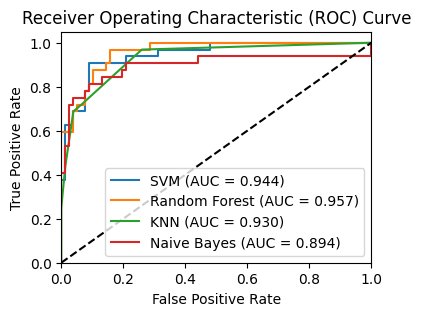


Models with highest metrics:
Highest Accuracy: KNN with 0.881 (88.1%)
Highest Precision: KNN with 0.881 (88.1%)
Highest Recall: KNN with 0.881 (88.1%)
Highest F1 Score: KNN with 0.876 (87.6%)
Highest AUC Score: Random Forest with 0.957 (95.7%)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# Load the input CSV file
main_data = pd.read_csv('ss.csv')  # Replace with your main dataset file path

# Drop rows with missing target values
main_data.dropna(subset=['PCOS (Y/N)'], inplace=True)

# Convert 'PCOS (Y/N)' to numeric if needed
y = main_data['PCOS (Y/N)'].astype(int)

# Define the feature set (X) by dropping non-numeric and target columns
X = main_data.drop(['PCOS (Y/N)'], axis=1)

# Convert any non-numeric columns to numeric using label encoding
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Check if there are any NaN values and fill or remove them
X.fillna(X.mean(), inplace=True)  # Fill NaNs with column means

# Feature scaling (recommended for SVM and KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the machine learning models
models = {
    'SVM': SVC(probability=True),
    'Linear Regression': LinearRegression(),  # Added Linear Regression
    'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Perceptron': Perceptron()
}

# Dictionary to store the results
results = {}

# Set up plot for ROC curve with an even smaller size
plt.figure(figsize=(4, 3))  # Further reduced size

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Convert Linear Regression predictions to binary
    if model_name == 'Linear Regression':
        y_pred_binary = np.round(y_pred)  # Convert predictions to binary
    else:
        y_pred_binary = y_pred

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_binary, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_binary, average='weighted', zero_division=0)

    # AUC is calculated for models that provide predict_proba
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    else:
        auc_score = 0.0  # Set AUC to 0 if not applicable

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc_score
    }

# Create a DataFrame for displaying the results
results_df = pd.DataFrame(results).T

# Formatting the output for better presentation (percentage format)
for metric in results_df.columns:
    results_df[metric] = results_df[metric].apply(lambda x: f"{x:.3f} ({x * 100:.1f}%)" if x is not None else "0.000 (0.0%)")

# Display the results in a table format
print("Model Evaluation Metrics:")
print(results_df.to_string(index=True, header=True))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Finding the model with the highest metrics
highest_accuracy_model = results_df['Accuracy'].idxmax()
highest_precision_model = results_df['Precision'].idxmax()
highest_recall_model = results_df['Recall'].idxmax()
highest_f1_model = results_df['F1 Score'].idxmax()
highest_auc_model = results_df['AUC Score'].idxmax()

# Display the highest metrics models
print("\nModels with highest metrics:")
print(f"Highest Accuracy: {highest_accuracy_model} with {results_df['Accuracy'][highest_accuracy_model]}")
print(f"Highest Precision: {highest_precision_model} with {results_df['Precision'][highest_precision_model]}")
print(f"Highest Recall: {highest_recall_model} with {results_df['Recall'][highest_recall_model]}")
print(f"Highest F1 Score: {highest_f1_model} with {results_df['F1 Score'][highest_f1_model]}")
print(f"Highest AUC Score: {highest_auc_model} with {results_df['AUC Score'][highest_auc_model]}")


Model Evaluation Metrics:
                        Accuracy      Precision         Recall       F1 Score      AUC Score
SVM                0.948 (94.8%)  0.948 (94.8%)  0.948 (94.8%)  0.947 (94.7%)  0.990 (99.0%)
Linear Regression  0.885 (88.5%)  0.888 (88.8%)  0.885 (88.5%)  0.882 (88.2%)   0.000 (0.0%)
Random Forest      0.961 (96.1%)  0.963 (96.3%)  0.961 (96.1%)  0.960 (96.0%)  0.996 (99.6%)
KNN                0.879 (87.9%)  0.892 (89.2%)  0.879 (87.9%)  0.872 (87.2%)  0.984 (98.4%)
Naive Bayes        0.852 (85.2%)  0.856 (85.6%)  0.852 (85.2%)  0.846 (84.6%)  0.874 (87.4%)
Perceptron         0.902 (90.2%)  0.901 (90.1%)  0.902 (90.2%)  0.901 (90.1%)   0.000 (0.0%)


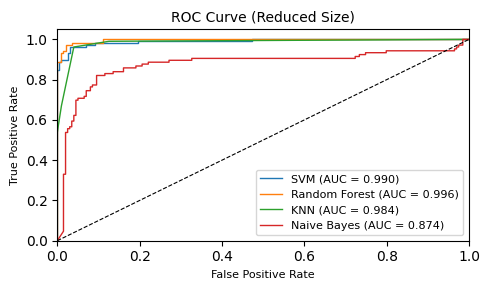


Models with highest metrics:
Highest Accuracy: Random Forest with 0.961 (96.1%)
Highest Precision: Random Forest with 0.963 (96.3%)
Highest Recall: Random Forest with 0.961 (96.1%)
Highest F1 Score: Random Forest with 0.960 (96.0%)
Highest AUC Score: Random Forest with 0.996 (99.6%)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# Load the input CSV files
main_data = pd.read_csv('ss.csv')  # Replace with your main dataset file path
ensemble_features = pd.read_csv('final_ensemble_features.csv')  # Replace with your ensemble features file path

# Merge datasets on 'AMH(ng/mL)' (use inner join to only keep rows that exist in both datasets)
df = pd.merge(main_data, ensemble_features, on='AMH(ng/mL)', how='inner')

# Drop any duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Drop rows with missing target values
df.dropna(subset=['PCOS (Y/N)_x'], inplace=True)

# Convert 'PCOS (Y/N)_x' to numeric if needed
y = df['PCOS (Y/N)_x'].astype(int)

# Define the feature set (X) by dropping non-numeric and target columns
X = df.drop(['PCOS (Y/N)_x', 'PCOS (Y/N)_y'], axis=1)

# Convert any non-numeric columns to numeric using label encoding
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Check if there are any NaN values and fill or remove them
X.fillna(X.mean(), inplace=True)  # Fill NaNs with column means

# Feature scaling (optional, but recommended for SVM and KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the machine learning models
models = {
    'SVM': SVC(probability=True),
    'Linear Regression': LinearRegression(),  # Not suitable for classification but included
    'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=10,
                                            min_samples_leaf=4, max_features='sqrt', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Perceptron': Perceptron()
}

# Dictionary to store the results
results = {}

# Set up a smaller plot for the ROC curve
plt.figure(figsize=(5, 3))  # Further reduce the size to (5x3)

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # For Linear Regression, we'll convert predictions to binary
    if model_name == 'Linear Regression':
        y_pred = (y_pred >= 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # AUC is calculated for models that provide predict_proba
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=1)  # Reduce line width

    else:
        auc_score = 0.0  # Set AUC to 0 if not applicable

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc_score
    }

# Create a DataFrame for displaying the results
results_df = pd.DataFrame(results).T

# Formatting the output for better presentation (percentage format)
for metric in results_df.columns:
    results_df[metric] = results_df[metric].apply(lambda x: f"{x:.3f} ({x * 100:.1f}%)" if x is not None else "0.000 (0.0%)")

# Display the results in a table format
print("Model Evaluation Metrics:")
print(results_df.to_string(index=True, header=True))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)  # Diagonal line for random guessing with reduced line width
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=8)  # Reduce font size
plt.ylabel('True Positive Rate', fontsize=8)  # Reduce font size
plt.title('ROC Curve (Reduced Size)', fontsize=10)  # Reduce font size
plt.legend(loc="lower right", fontsize=8)  # Reduce font size in legend
plt.tight_layout()  # Ensure the layout fits within the figure size
plt.show()

# Finding the model with the highest metrics
highest_accuracy_model = results_df['Accuracy'].idxmax()
highest_precision_model = results_df['Precision'].idxmax()
highest_recall_model = results_df['Recall'].idxmax()
highest_f1_model = results_df['F1 Score'].idxmax()
highest_auc_model = results_df['AUC Score'].idxmax()

# Display the highest metrics models
print("\nModels with highest metrics:")
print(f"Highest Accuracy: {highest_accuracy_model} with {results_df['Accuracy'][highest_accuracy_model]}")
print(f"Highest Precision: {highest_precision_model} with {results_df['Precision'][highest_precision_model]}")
print(f"Highest Recall: {highest_recall_model} with {results_df['Recall'][highest_recall_model]}")
print(f"Highest F1 Score: {highest_f1_model} with {results_df['F1 Score'][highest_f1_model]}")
print(f"Highest AUC Score: {highest_auc_model} with {results_df['AUC Score'][highest_auc_model]}")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the input CSV files
main_data = pd.read_csv('ss.csv')  # Replace with your main dataset file path
ensemble_features = pd.read_csv('final_ensemble_features.csv')  # Replace with your ensemble features file path

# Merge datasets on 'AMH(ng/mL)' (use inner join to only keep rows that exist in both datasets)
df = pd.merge(main_data, ensemble_features, on='AMH(ng/mL)', how='inner')

# Drop any duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Drop rows with missing target values
df.dropna(subset=['PCOS (Y/N)_x'], inplace=True)

# Convert 'PCOS (Y/N)_x' to numeric if needed (already seems numeric from your data)
y = df['PCOS (Y/N)_x'].astype(int)

# Define the feature set (X) by dropping non-numeric and target columns
X = df.drop(['PCOS (Y/N)_x', 'PCOS (Y/N)_y'], axis=1)

# Convert any non-numeric columns to numeric using label encoding or one-hot encoding
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Check if there are any NaN values and fill or remove them
X.fillna(X.mean(), inplace=True)  # Fill NaNs with column means

# Feature scaling (optional, but recommended for SVM and KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the machine learning models (with hyperparameter tuning for Random Forest)
models = {
    'SVM': SVC(probability=True),
    'Linear Regression': LinearRegression(),  # Not suitable for classification but included
    'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=10,
                                            min_samples_leaf=4, max_features='sqrt', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Perceptron': Perceptron()
}

# Dictionary to store the results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # For Linear Regression, we'll convert predictions to binary
    if model_name == 'Linear Regression':
        y_pred = (y_pred >= 0.5).astype(int)
        # For AUC, we'll predict probabilities using the linear regression output
        y_prob = model.predict(X_test)  # Use the predicted continuous values for AUC
    else:
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # AUC calculation
    auc = roc_auc_score(y_test, y_prob) if len(set(y)) > 1 else 0.0  # Check for binary classes before AUC

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc
    }

# Create a DataFrame for displaying the results
results_df = pd.DataFrame(results).T

# Formatting the output for better presentation (percentage format)
for metric in results_df.columns:
    results_df[metric] = results_df[metric].apply(lambda x: f"{x:.3f} ({x * 100:.1f}%)" if x is not None else "0.000 (0.0%)")

# Display the results in a table format
print("Model Evaluation Metrics:")
print(results_df.to_string(index=True, header=True))

# Finding the model with the highest metrics
highest_accuracy_model = results_df['Accuracy'].idxmax()
highest_precision_model = results_df['Precision'].idxmax()
highest_recall_model = results_df['Recall'].idxmax()
highest_f1_model = results_df['F1 Score'].idxmax()
highest_auc_model = results_df['AUC Score'].idxmax()

# Display the highest metrics models
print("\nModels with highest metrics:")
print(f"Highest Accuracy: {highest_accuracy_model} with {results_df['Accuracy'][highest_accuracy_model]}")
print(f"Highest Precision: {highest_precision_model} with {results_df['Precision'][highest_precision_model]}")
print(f"Highest Recall: {highest_recall_model} with {results_df['Recall'][highest_recall_model]}")
print(f"Highest F1 Score: {highest_f1_model} with {results_df['F1 Score'][highest_f1_model]}")
print(f"Highest AUC Score: {highest_auc_model} with {results_df['AUC Score'][highest_auc_model]}")


Model Evaluation Metrics:
                        Accuracy      Precision         Recall       F1 Score      AUC Score
SVM                0.948 (94.8%)  0.948 (94.8%)  0.948 (94.8%)  0.947 (94.7%)  0.990 (99.0%)
Linear Regression  0.885 (88.5%)  0.888 (88.8%)  0.885 (88.5%)  0.882 (88.2%)  0.955 (95.5%)
Random Forest      0.961 (96.1%)  0.963 (96.3%)  0.961 (96.1%)  0.960 (96.0%)  0.996 (99.6%)
KNN                0.879 (87.9%)  0.892 (89.2%)  0.879 (87.9%)  0.872 (87.2%)  0.984 (98.4%)
Naive Bayes        0.852 (85.2%)  0.856 (85.6%)  0.852 (85.2%)  0.846 (84.6%)  0.874 (87.4%)
Perceptron         0.902 (90.2%)  0.901 (90.1%)  0.902 (90.2%)  0.901 (90.1%)  0.931 (93.1%)

Models with highest metrics:
Highest Accuracy: Random Forest with 0.961 (96.1%)
Highest Precision: Random Forest with 0.963 (96.3%)
Highest Recall: Random Forest with 0.961 (96.1%)
Highest F1 Score: Random Forest with 0.960 (96.0%)
Highest AUC Score: Random Forest with 0.996 (99.6%)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the input CSV file
df = pd.read_csv('ss.csv')  # Replace with your main dataset file path

# Drop rows with missing target values
df.dropna(subset=['PCOS (Y/N)'], inplace=True)

# Convert 'PCOS (Y/N)' to numeric if needed
y = df['PCOS (Y/N)'].astype(int)

# Define the feature set (X) by dropping non-numeric and target columns
X = df.drop(['PCOS (Y/N)'], axis=1)

# Convert any non-numeric columns to numeric using label encoding or one-hot encoding
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Check if there are any NaN values and fill or remove them
X.fillna(X.mean(), inplace=True)  # Fill NaNs with column means

# Feature scaling (optional, but recommended for SVM and KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the machine learning models (with hyperparameter tuning for Random Forest)
models = {
    'SVM': SVC(probability=True),
    'Linear Regression': LinearRegression(),  # Not suitable for classification but included
    'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=10,
                                            min_samples_leaf=4, max_features='sqrt', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Perceptron': Perceptron()
}

# Dictionary to store the results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # For Linear Regression, we'll convert predictions to binary
    if model_name == 'Linear Regression':
        y_pred = (y_pred >= 0.5).astype(int)
        # For AUC, we'll predict probabilities using the linear regression output
        y_prob = model.predict(X_test)  # Use the predicted continuous values for AUC
    else:
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # AUC calculation
    auc = roc_auc_score(y_test, y_prob) if len(set(y)) > 1 else 0.0  # Check for binary classes before AUC

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc
    }

# Create a DataFrame for displaying the results
results_df = pd.DataFrame(results).T

# Formatting the output for better presentation (percentage format)
for metric in results_df.columns:
    results_df[metric] = results_df[metric].apply(lambda x: f"{x:.3f} ({x * 100:.1f}%)" if x is not None else "0.000 (0.0%)")

# Display the results in a table format
print("Model Evaluation Metrics:")
print(results_df.to_string(index=True, header=True))

# Finding the model with the highest metrics
highest_accuracy_model = results_df['Accuracy'].idxmax()
highest_precision_model = results_df['Precision'].idxmax()
highest_recall_model = results_df['Recall'].idxmax()
highest_f1_model = results_df['F1 Score'].idxmax()
highest_auc_model = results_df['AUC Score'].idxmax()

# Display the highest metrics models
print("\nModels with highest metrics:")
print(f"Highest Accuracy: {highest_accuracy_model} with {results_df['Accuracy'][highest_accuracy_model]}")
print(f"Highest Precision: {highest_precision_model} with {results_df['Precision'][highest_precision_model]}")
print(f"Highest Recall: {highest_recall_model} with {results_df['Recall'][highest_recall_model]}")
print(f"Highest F1 Score: {highest_f1_model} with {results_df['F1 Score'][highest_f1_model]}")
print(f"Highest AUC Score: {highest_auc_model} with {results_df['AUC Score'][highest_auc_model]}")


Model Evaluation Metrics:
                        Accuracy      Precision         Recall       F1 Score      AUC Score
SVM                0.862 (86.2%)  0.863 (86.3%)  0.862 (86.2%)  0.855 (85.5%)  0.944 (94.4%)
Linear Regression  0.872 (87.2%)  0.870 (87.0%)  0.872 (87.2%)  0.867 (86.7%)  0.926 (92.6%)
Random Forest      0.881 (88.1%)  0.881 (88.1%)  0.881 (88.1%)  0.876 (87.6%)  0.957 (95.7%)
KNN                0.881 (88.1%)  0.881 (88.1%)  0.881 (88.1%)  0.876 (87.6%)  0.930 (93.0%)
Naive Bayes        0.872 (87.2%)  0.874 (87.4%)  0.872 (87.2%)  0.873 (87.3%)  0.894 (89.4%)
Perceptron         0.835 (83.5%)  0.835 (83.5%)  0.835 (83.5%)  0.835 (83.5%)  0.910 (91.0%)

Models with highest metrics:
Highest Accuracy: Random Forest with 0.881 (88.1%)
Highest Precision: Random Forest with 0.881 (88.1%)
Highest Recall: Random Forest with 0.881 (88.1%)
Highest F1 Score: Random Forest with 0.876 (87.6%)
Highest AUC Score: Random Forest with 0.957 (95.7%)


Model Evaluation Metrics:
                        Accuracy      Precision         Recall       F1 Score      AUC Score
SVM                0.862 (86.2%)  0.863 (86.3%)  0.862 (86.2%)  0.855 (85.5%)  0.944 (94.4%)
Linear Regression  0.872 (87.2%)  0.870 (87.0%)  0.872 (87.2%)  0.867 (86.7%)  0.926 (92.6%)
Random Forest      0.872 (87.2%)  0.870 (87.0%)  0.872 (87.2%)  0.867 (86.7%)  0.957 (95.7%)
KNN                0.881 (88.1%)  0.881 (88.1%)  0.881 (88.1%)  0.876 (87.6%)  0.930 (93.0%)
Naive Bayes        0.872 (87.2%)  0.874 (87.4%)  0.872 (87.2%)  0.873 (87.3%)  0.894 (89.4%)
Perceptron         0.835 (83.5%)  0.835 (83.5%)  0.835 (83.5%)  0.835 (83.5%)  0.910 (91.0%)


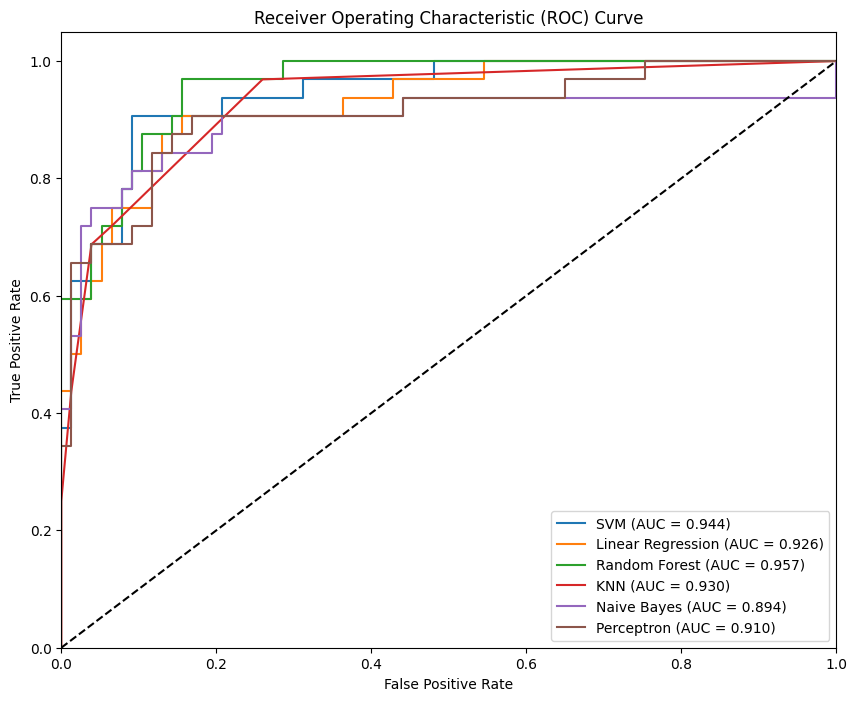


Models with highest metrics:
Highest Accuracy: KNN with 0.881 (88.1%)
Highest Precision: KNN with 0.881 (88.1%)
Highest Recall: KNN with 0.881 (88.1%)
Highest F1 Score: KNN with 0.876 (87.6%)
Highest AUC Score: Random Forest with 0.957 (95.7%)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# Load the input CSV file
main_data = pd.read_csv('ss.csv')  # Replace with your main dataset file path

# Drop rows with missing target values
main_data.dropna(subset=['PCOS (Y/N)'], inplace=True)

# Convert 'PCOS (Y/N)' to numeric if needed
y = main_data['PCOS (Y/N)'].astype(int)

# Define the feature set (X) by dropping non-numeric and target columns
X = main_data.drop(['PCOS (Y/N)'], axis=1)

# Convert any non-numeric columns to numeric using label encoding
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Check if there are any NaN values and fill or remove them
X.fillna(X.mean(), inplace=True)  # Fill NaNs with column means

# Feature scaling (recommended for SVM and KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the machine learning models
models = {
    'SVM': SVC(probability=True),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Perceptron': Perceptron()
}

# Dictionary to store the results
results = {}

# Set up plot for ROC curve
plt.figure(figsize=(10, 8))

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Convert Linear Regression predictions to binary
    if model_name == 'Linear Regression':
        y_pred_binary = np.round(y_pred)  # Convert predictions to binary
    else:
        y_pred_binary = y_pred

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_binary, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_binary, average='weighted', zero_division=0)

    # Handle ROC curve generation
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)  # Decision function for classifiers like SVM
    else:
        y_proba = y_pred  # For models without decision_function or predict_proba, use predicted values

    # AUC calculation
    if len(set(y_test)) > 1:  # Check for at least two classes before AUC
        auc_score = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    else:
        auc_score = 0.0

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc_score
    }

# Create a DataFrame for displaying the results
results_df = pd.DataFrame(results).T

# Formatting the output for better presentation (percentage format)
for metric in results_df.columns:
    results_df[metric] = results_df[metric].apply(lambda x: f"{x:.3f} ({x * 100:.1f}%)" if x is not None else "0.000 (0.0%)")

# Display the results in a table format
print("Model Evaluation Metrics:")
print(results_df.to_string(index=True, header=True))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Finding the model with the highest metrics
highest_accuracy_model = results_df['Accuracy'].idxmax()
highest_precision_model = results_df['Precision'].idxmax()
highest_recall_model = results_df['Recall'].idxmax()
highest_f1_model = results_df['F1 Score'].idxmax()
highest_auc_model = results_df['AUC Score'].idxmax()

# Display the highest metrics models
print("\nModels with highest metrics:")
print(f"Highest Accuracy: {highest_accuracy_model} with {results_df['Accuracy'][highest_accuracy_model]}")
print(f"Highest Precision: {highest_precision_model} with {results_df['Precision'][highest_precision_model]}")
print(f"Highest Recall: {highest_recall_model} with {results_df['Recall'][highest_recall_model]}")
print(f"Highest F1 Score: {highest_f1_model} with {results_df['F1 Score'][highest_f1_model]}")
print(f"Highest AUC Score: {highest_auc_model} with {results_df['AUC Score'][highest_auc_model]}")


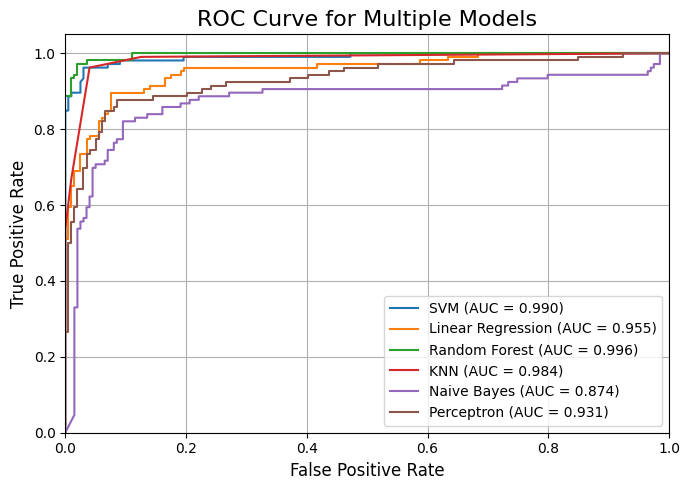

Model Evaluation Metrics:
                        Accuracy      Precision         Recall       F1 Score      AUC Score
SVM                0.948 (94.8%)  0.948 (94.8%)  0.948 (94.8%)  0.947 (94.7%)  0.990 (99.0%)
Linear Regression  0.885 (88.5%)  0.888 (88.8%)  0.885 (88.5%)  0.882 (88.2%)  0.955 (95.5%)
Random Forest      0.961 (96.1%)  0.963 (96.3%)  0.961 (96.1%)  0.960 (96.0%)  0.996 (99.6%)
KNN                0.879 (87.9%)  0.892 (89.2%)  0.879 (87.9%)  0.872 (87.2%)  0.984 (98.4%)
Naive Bayes        0.852 (85.2%)  0.856 (85.6%)  0.852 (85.2%)  0.846 (84.6%)  0.874 (87.4%)
Perceptron         0.902 (90.2%)  0.901 (90.1%)  0.902 (90.2%)  0.901 (90.1%)  0.931 (93.1%)

Models with highest metrics:
Highest Accuracy: Random Forest with 0.961 (96.1%)
Highest Precision: Random Forest with 0.963 (96.3%)
Highest Recall: Random Forest with 0.961 (96.1%)
Highest F1 Score: Random Forest with 0.960 (96.0%)
Highest AUC Score: Random Forest with 0.996 (99.6%)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# Load the input CSV files
main_data = pd.read_csv('ss.csv')  # Replace with your main dataset file path
ensemble_features = pd.read_csv('final_ensemble_features.csv')  # Replace with your ensemble features file path

# Merge datasets on 'AMH(ng/mL)' (use inner join to only keep rows that exist in both datasets)
df = pd.merge(main_data, ensemble_features, on='AMH(ng/mL)', how='inner')

# Drop any duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Drop rows with missing target values
df.dropna(subset=['PCOS (Y/N)_x'], inplace=True)

# Convert 'PCOS (Y/N)_x' to numeric if needed
y = df['PCOS (Y/N)_x'].astype(int)

# Define the feature set (X) by dropping non-numeric and target columns
X = df.drop(['PCOS (Y/N)_x', 'PCOS (Y/N)_y'], axis=1)

# Convert any non-numeric columns to numeric using label encoding
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Check if there are any NaN values and fill or remove them
X.fillna(X.mean(), inplace=True)  # Fill NaNs with column means

# Feature scaling (optional, but recommended for SVM and KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the machine learning models
models = {
    'SVM': SVC(probability=True),
    'Linear Regression': LinearRegression(),  # Not suitable for classification but included
    'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=10,
                                            min_samples_leaf=4, max_features='sqrt', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Perceptron': Perceptron()
}

# Dictionary to store the results
results = {}

# Set up the ROC curve plot
plt.figure(figsize=(7, 5))  # Adjust size as needed

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # For Linear Regression, we'll convert predictions to binary
    if model_name == 'Linear Regression':
        y_pred = (y_pred >= 0.5).astype(int)
        # For AUC, we'll predict probabilities using the linear regression output
        y_prob = model.predict(X_test)  # Use the predicted continuous values for AUC
    else:
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # AUC calculation
    auc = roc_auc_score(y_test, y_prob) if len(set(y)) > 1 else 0.0  # Check for binary classes before AUC

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc
    }

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')

# Set up the plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Multiple Models', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid()

# Display the ROC curve plot
plt.tight_layout()  # Ensure the layout fits within the figure size
plt.show()

# Create a DataFrame for displaying the results
results_df = pd.DataFrame(results).T

# Formatting the output for better presentation (percentage format)
for metric in results_df.columns:
    results_df[metric] = results_df[metric].apply(lambda x: f"{x:.3f} ({x * 100:.1f}%)" if x is not None else "0.000 (0.0%)")

# Display the results in a table format
print("Model Evaluation Metrics:")
print(results_df.to_string(index=True, header=True))

# Finding the model with the highest metrics
highest_accuracy_model = results_df['Accuracy'].idxmax()
highest_precision_model = results_df['Precision'].idxmax()
highest_recall_model = results_df['Recall'].idxmax()
highest_f1_model = results_df['F1 Score'].idxmax()
highest_auc_model = results_df['AUC Score'].idxmax()

# Display the highest metrics models
print("\nModels with highest metrics:")
print(f"Highest Accuracy: {highest_accuracy_model} with {results_df['Accuracy'][highest_accuracy_model]}")
print(f"Highest Precision: {highest_precision_model} with {results_df['Precision'][highest_precision_model]}")
print(f"Highest Recall: {highest_recall_model} with {results_df['Recall'][highest_recall_model]}")
print(f"Highest F1 Score: {highest_f1_model} with {results_df['F1 Score'][highest_f1_model]}")
print(f"Highest AUC Score: {highest_auc_model} with {results_df['AUC Score'][highest_auc_model]}")


Model Evaluation Metrics:
                        Accuracy      Precision         Recall       F1 Score      AUC Score
SVM                0.862 (86.2%)  0.863 (86.3%)  0.862 (86.2%)  0.855 (85.5%)  0.944 (94.4%)
Linear Regression  0.872 (87.2%)  0.870 (87.0%)  0.872 (87.2%)  0.867 (86.7%)  0.926 (92.6%)
Random Forest      0.872 (87.2%)  0.870 (87.0%)  0.872 (87.2%)  0.867 (86.7%)  0.957 (95.7%)
KNN                0.881 (88.1%)  0.881 (88.1%)  0.881 (88.1%)  0.876 (87.6%)  0.930 (93.0%)
Naive Bayes        0.872 (87.2%)  0.874 (87.4%)  0.872 (87.2%)  0.873 (87.3%)  0.894 (89.4%)
Perceptron         0.835 (83.5%)  0.835 (83.5%)  0.835 (83.5%)  0.835 (83.5%)  0.910 (91.0%)


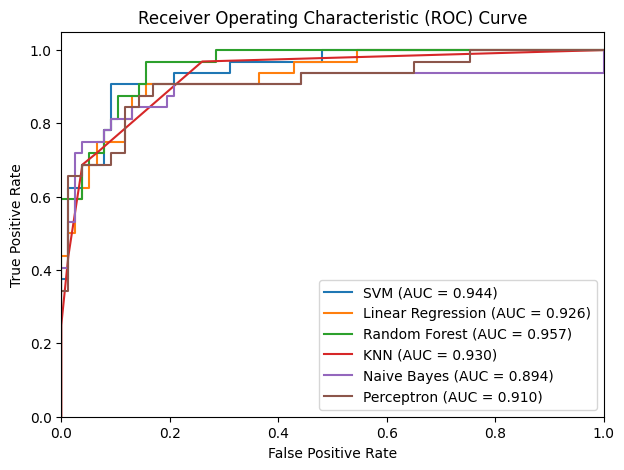


Models with highest metrics:
Highest Accuracy: KNN with 0.881 (88.1%)
Highest Precision: KNN with 0.881 (88.1%)
Highest Recall: KNN with 0.881 (88.1%)
Highest F1 Score: KNN with 0.876 (87.6%)
Highest AUC Score: Random Forest with 0.957 (95.7%)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# Load the input CSV file
main_data = pd.read_csv('ss.csv')  # Replace with your main dataset file path

# Drop rows with missing target values
main_data.dropna(subset=['PCOS (Y/N)'], inplace=True)

# Convert 'PCOS (Y/N)' to numeric if needed
y = main_data['PCOS (Y/N)'].astype(int)

# Define the feature set (X) by dropping non-numeric and target columns
X = main_data.drop(['PCOS (Y/N)'], axis=1)

# Convert any non-numeric columns to numeric using label encoding
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Check if there are any NaN values and fill or remove them
X.fillna(X.mean(), inplace=True)  # Fill NaNs with column means

# Feature scaling (recommended for SVM and KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the machine learning models
models = {
    'SVM': SVC(probability=True),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Perceptron': Perceptron()
}

# Dictionary to store the results
results = {}

# Set up plot for ROC curve
plt.figure(figsize=(7, 5))

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Convert Linear Regression predictions to binary
    if model_name == 'Linear Regression':
        y_pred_binary = np.round(y_pred)  # Convert predictions to binary
    else:
        y_pred_binary = y_pred

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_binary, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_binary, average='weighted', zero_division=0)

    # Handle ROC curve generation
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)  # Decision function for classifiers like SVM
    else:
        y_proba = y_pred  # For models without decision_function or predict_proba, use predicted values

    # AUC calculation
    if len(set(y_test)) > 1:  # Check for at least two classes before AUC
        auc_score = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    else:
        auc_score = 0.0

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc_score
    }

# Create a DataFrame for displaying the results
results_df = pd.DataFrame(results).T

# Formatting the output for better presentation (percentage format)
for metric in results_df.columns:
    results_df[metric] = results_df[metric].apply(lambda x: f"{x:.3f} ({x * 100:.1f}%)" if x is not None else "0.000 (0.0%)")

# Display the results in a table format
print("Model Evaluation Metrics:")
print(results_df.to_string(index=True, header=True))

# Plot ROC curve (without random guessing line)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Finding the model with the highest metrics
highest_accuracy_model = results_df['Accuracy'].idxmax()
highest_precision_model = results_df['Precision'].idxmax()
highest_recall_model = results_df['Recall'].idxmax()
highest_f1_model = results_df['F1 Score'].idxmax()
highest_auc_model = results_df['AUC Score'].idxmax()

# Display the highest metrics models
print("\nModels with highest metrics:")
print(f"Highest Accuracy: {highest_accuracy_model} with {results_df['Accuracy'][highest_accuracy_model]}")
print(f"Highest Precision: {highest_precision_model} with {results_df['Precision'][highest_precision_model]}")
print(f"Highest Recall: {highest_recall_model} with {results_df['Recall'][highest_recall_model]}")
print(f"Highest F1 Score: {highest_f1_model} with {results_df['F1 Score'][highest_f1_model]}")
print(f"Highest AUC Score: {highest_auc_model} with {results_df['AUC Score'][highest_auc_model]}")
